- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints -  Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-- fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# imports and initializing dataframes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

train = pd.read_csv('train_V2.csv')
test = pd.read_csv('test_V2.csv')
data = pd.concat([train, test]).reset_index()
data = data.drop('index', axis=1)

train_shape = train.shape
test_shape = test.shape
print(train_shape, test_shape)
data.tail()

(4446966, 29) (1934174, 28)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
6381135,a316c3a13887d5,80e82180c90951,f276da5fd73536,1,2,381.00,3,0,7,4,...,1,0.0,0,0.000,0,0,1799.00,5,1526,NaN
6381136,5312146b27d875,147264a127c56e,fb77cbfe094a6b,0,0,0.00,0,0,0,64,...,0,0.0,0,0.000,0,0,1195.00,3,1496,NaN
6381137,fc8818b5b32ad3,7bbb4779ebedd5,efb74d5f6e9779,0,0,91.96,0,0,3,24,...,0,0.0,0,7.798,1,0,3327.00,3,0,NaN
6381138,a0f91e35f8458f,149a506a64c2b1,3a2cf335bc302f,1,2,138.60,0,0,12,25,...,1,0.0,0,0.000,0,0,1893.00,4,0,NaN
6381139,3696fc9f3a42b2,c770d7feaf020f,9d4e2b6d506fd0,0,0,19.80,0,0,0,86,...,0,0.0,0,0.000,0,0,68.89,0,1551,NaN


In [3]:
def split_data(data):
    train = data.iloc[:4446966, :]
    test = data.iloc[4446966:, :].drop('winPlacePerc', axis=1)
    return train, test

In [4]:
train, test = split_data(data)
train.shape
test.shape

(1934174, 28)

# basic correlations

In [5]:
train.sample(10000).corr()['winPlacePerc'].sort_values(ascending=False)

winPlacePerc       1.000000
walkDistance       0.818674
boosts             0.640943
weaponsAcquired    0.587468
damageDealt        0.436009
heals              0.432588
kills              0.421709
longestKill        0.414720
killStreaks        0.382526
rideDistance       0.326758
assists            0.292584
headshotKills      0.279515
DBNOs              0.277430
revives            0.230631
swimDistance       0.149342
vehicleDestroys    0.072902
numGroups          0.041600
roadKills          0.041088
maxPlace           0.038642
rankPoints         0.030894
teamKills          0.010610
killPoints        -0.003386
winPoints         -0.010412
matchDuration     -0.011830
killPlace         -0.718966
Name: winPlacePerc, dtype: float64

In [6]:
train['win'] = train['winPlacePerc'] == 1
train['t10'] = train['winPlacePerc'] >= 0.9

data['totalDistance'] = data['walkDistance'].add(data['rideDistance']).add(data['swimDistance'])
data['pct_headshot'] = data['headshotKills'].div(data['kills'])
#drop_values = ['normal-squad-fpp', 'crashfpp',
#        'normal-duo-fpp', 'flaretpp',
#        'normal-solo-fpp', 'flarefpp',
#        'normal-squad', 'crashtpp',
#         'normal-solo', 'normal-duo']
#drop = train.matchType.isin(drop_values)
#train = train[~drop]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# let's take a look at the data

In [7]:
pd.set_option('display.max_columns', None)
data['matchType'] = data['matchType'].str.replace('-', ' ')
data['fpp'] = data.matchType.str.contains('fpp')
data['matchType'] = data['matchType'].str.replace(' fpp', '')
data['matchType'] = data['matchType'].str.replace('fpp', '')
data['matchType'] = data['matchType'].str.replace('tpp', '')
data['matchType'] = data['matchType'].str.replace('normal ', '')
data.matchType.value_counts()

squad    3432716
duo      1900256
solo     1034637
crash       9537
flare       3994
Name: matchType, dtype: int64

<AxesSubplot:>

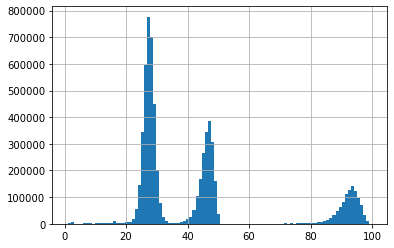

In [8]:
data.numGroups.hist(bins=100)

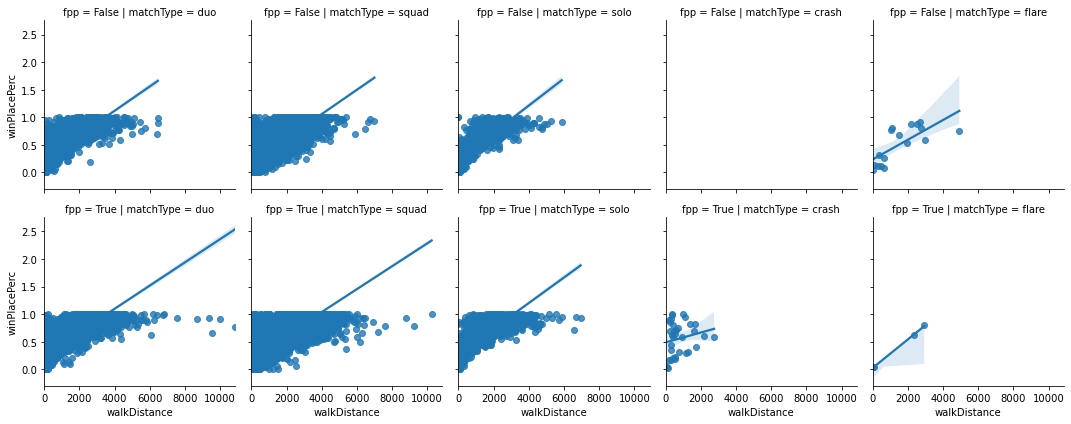

In [9]:
g = sns.FacetGrid(data.sample(40000), col='matchType', row='fpp')
g.map(sns.regplot, 'walkDistance', 'winPlacePerc')
g

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


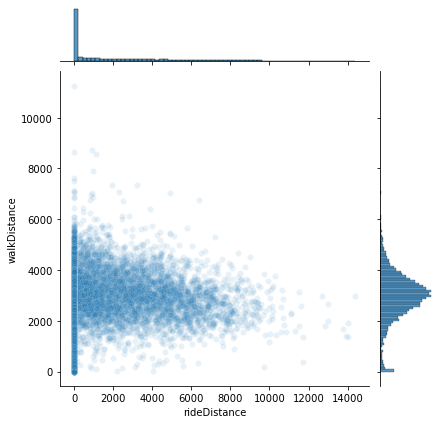

In [10]:
winners = data.loc[data['winPlacePerc'] == 1]
sns.jointplot('rideDistance', 'walkDistance', alpha=0.1, data=winners.sample(10000))

<AxesSubplot:xlabel='walkDistance', ylabel='Density'>

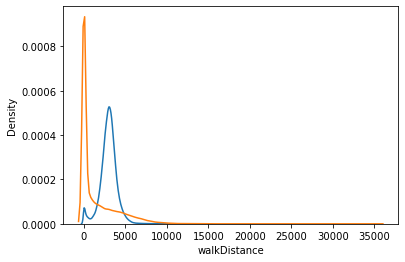

In [11]:
sns.kdeplot('walkDistance', data=winners)
sns.kdeplot('rideDistance', data=winners)

array([[<AxesSubplot:title={'center':'killPoints'}>]], dtype=object)

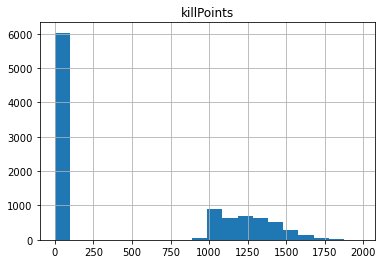

In [12]:
train.sample(10000).hist('killPoints', bins=20)

In [13]:
sample = train.sample(30000)
sample = sample.loc[sample['walkDistance'] < 10000]
qlabels = range(1, 11)
qtiles = pd.qcut(sample['walkDistance'], len(qlabels), labels=qlabels)
print('Placement percentile by walk distance quantile:')
sample['winPlacePerc'].groupby(qtiles).mean()

Placement percentile by walk distance quantile:


walkDistance
1     0.093254
2     0.159893
3     0.227464
4     0.303152
5     0.391255
6     0.504965
7     0.628260
8     0.729859
9     0.817498
10    0.868253
Name: winPlacePerc, dtype: float64

In [14]:
sample.groupby(qtiles)['win'].mean()

walkDistance
1     0.002333
2     0.001000
3     0.001000
4     0.001333
5     0.003334
6     0.002993
7     0.012358
8     0.031000
9     0.073333
10    0.150100
Name: win, dtype: float64

In [15]:
far_car = sample.loc[sample['rideDistance'] > 1000]['win'].mean()
car = sample.loc[sample['rideDistance'] > 0]['win'].mean()
no_car = sample.loc[sample['rideDistance'] == 0]['win'].mean()

used_car = sample.loc[sample['rideDistance'] > 0]


print(car, no_car, far_car)

0.05035783994795055 0.020122798368664006 0.05405932864949258


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


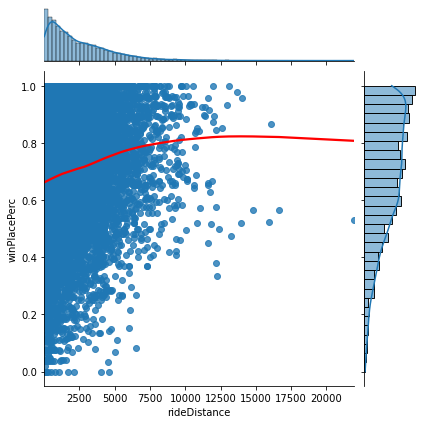

In [16]:
import statsmodels
g = sns.jointplot('rideDistance', 'winPlacePerc', data=used_car, kind='reg', lowess=True)
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


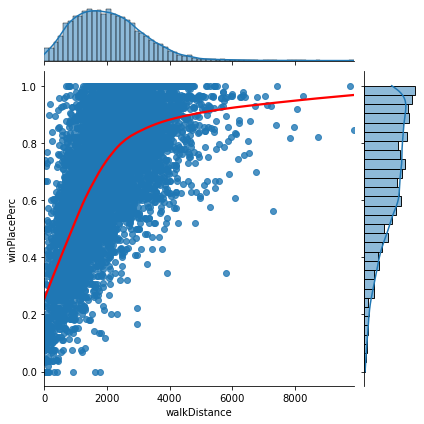

In [17]:
import statsmodels
g = sns.jointplot('walkDistance', 'winPlacePerc', data=used_car, kind='reg', lowess=True)
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


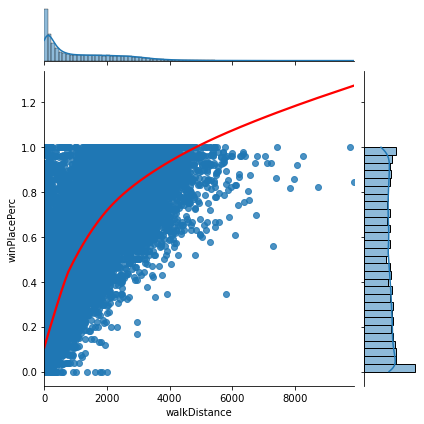

In [18]:
import statsmodels
g = sns.jointplot('walkDistance', 'winPlacePerc', data=sample, kind='reg', lowess=True)
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

So it looks like walk distance is highly predictive of how far a group goes into the game.
BUT... I'm thinking once a certain threshold of walking distance is met, there are probably other factors that will be much more predictive of whether the group wins or not.

Idea: after a certain threshold of walking distance, use other factors such as kills, boosts, etc to determine fighting skill of players to predict their ability to win once they get to the lategame.

In [19]:
top10 = train.loc[train['t10'] == True]
top10['winPlacePerc'] = top10.winPlacePerc.round(2)
top10.groupby('winPlacePerc').mean()
#corr = top10.corr()
#corr[['winPlacePerc', 'kills']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,win,t10
winPlacePerc,,,,,,,,,,,,,,,,,,,,,,,,,,
0.90,0.403571,2.954507,229.959235,0.825853,0.470588,3.081937,22.440137,555.415556,1.791244,0.859851,55.208469,1596.505687,54.392075,52.687294,865.792956,0.249113,1307.237674,0.011618,14.276469,0.016143,0.015776,2628.879130,5.421793,657.397945,False,True
0.91,0.389030,3.114549,243.133890,0.815597,0.497634,3.127614,20.838329,445.481293,1.935323,0.931036,57.835390,1610.626947,59.937305,57.940582,984.828378,0.244590,1371.527099,0.009141,14.445753,0.017878,0.015451,2638.918857,5.441775,547.051410,False,True
0.92,0.554682,3.102197,250.938230,1.251820,0.485241,3.224758,21.327937,517.626089,1.952597,0.953334,59.154371,1565.839682,41.525008,40.144978,905.933662,0.367369,1304.085408,0.007391,12.908249,0.021636,0.018131,2691.650616,5.352499,612.132206,False,True
0.93,0.606460,3.139277,258.321361,1.349926,0.484266,3.311885,21.117682,540.222643,1.982978,0.966775,61.861941,1583.825287,37.908865,36.641003,889.433580,0.397447,1402.688178,0.006678,12.818081,0.023018,0.019490,2769.712909,5.360224,624.803586,False,True
0.94,0.462120,3.372960,271.499402,0.940054,0.559342,3.164531,19.166089,534.759748,2.215596,1.012387,62.381801,1573.520118,59.344331,57.394461,887.248861,0.271375,1261.091878,0.010906,14.990539,0.016243,0.014763,2676.068878,5.415495,645.440346,False,True
0.95,0.303628,3.772772,288.484631,0.422910,0.663939,3.069006,16.299980,490.556881,2.441443,0.952188,67.452470,1620.172319,78.168080,75.814274,946.263703,0.125493,1399.518726,0.012224,16.185423,0.008971,0.014688,2675.721692,5.592074,600.010154,False,True
0.96,0.682246,3.463660,290.043625,1.502865,0.551558,3.461331,18.878678,519.447308,2.245783,1.044673,68.349132,1573.114477,37.670734,36.385330,917.130283,0.444807,1368.109556,0.006764,12.741433,0.020241,0.020200,2813.699893,5.384136,602.323171,False,True
0.97,0.564258,3.658043,301.394542,1.097019,0.624672,3.395997,17.593223,603.402606,2.421729,1.005484,70.320785,1582.291620,52.788245,51.203131,835.190007,0.331880,1308.762116,0.009702,13.752746,0.015701,0.019169,2786.644790,5.412167,692.604893,False,True
0.98,0.619349,4.208145,358.419581,1.205486,0.767632,3.556481,14.175049,490.126460,2.950283,1.163198,78.852126,1594.747023,57.916811,55.923055,954.123627,0.341282,1419.790713,0.010839,15.117385,0.012227,0.019627,2829.672181,5.547925,585.244595,False,True


In [20]:
team_values = data.groupby('groupId').sum().reset_index()
team_size = data.groupby('groupId').count().reset_index()

team_size = team_size[['groupId', 'Id']]
team_size.columns = ['groupId', 'teamSize']

team_size.teamSize.value_counts()
# team_values_train = train.groupby(by='groupId').sum().reset_index()
# team_values_test = test.groupby(by='groupId').sum().reset_index()

# team_size_train = train.groupby('groupId').count().reset_index()
# team_size_test = test.groupby('groupId').count().reset_index()
# team_values_train.nlargest(10, 'walkDistance')

1     1139670
2      943170
3      353165
4      311761
5       76594
6       37094
7       20994
8       12015
9        6908
10       4141
11       2581
12       1623
13       1140
14        770
15        485
16        323
17        204
18        144
19         80
20         33
21         26
22         22
23         13
26          7
25          4
24          3
28          2
27          2
36          1
64          1
63          1
49          1
72          1
35          1
31          1
30          1
74          1
Name: teamSize, dtype: int64

In [21]:
team_size.tail()
# team_size_train = team_size_train[['groupId', 'Id']]
# team_size_train.columns = ['groupId', 'teamSize']

# team_size_test = team_size_test[['groupId', 'Id']]
# team_size_test.columns = ['groupId', 'teamSize']

#team_size_train.teamSize.value_counts()

,groupId,teamSize
2912978,ffffeefefc52f4,4
2912979,fffff305a0133d,2
2912980,fffff32bc7eab9,1
2912981,fffff7edfc4050,2
2912982,fffff98178ef52,1


In [22]:
data = data.merge(team_size, on='groupId')
#train = train.merge(team_size_train, on='groupId')
#test = test.merge(team_size_test, on='groupId')
data.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,pct_headshot,fpp,teamSize
6381135,dadb017a444602,97572de2a4da68,00eaf1db913030,0,0,100.00,0,0,0,40,0,1,1,4.07,1441,solo,94,93,1477,0,0.0,0,0.0,0,0,91.190,1,0,NaN,91.190,0.0,True,1
6381136,4e876c8d185011,7e3ffcf069160d,d75584b6a89a04,0,0,42.57,0,0,0,66,1479,0,0,0.00,1362,solo,98,95,-1,0,0.0,0,0.0,0,0,299.600,1,1614,NaN,299.600,NaN,True,1
6381137,130020cd922eb9,355623b5def3e6,bdd686c2da1b5a,0,0,11.02,0,0,0,79,0,0,0,0.00,1854,solo,98,98,1491,0,0.0,0,0.0,0,0,117.000,2,0,NaN,117.000,NaN,True,1
6381138,760e8d8f9a798d,a64e0c1ca94fb2,e21d178e2e5eeb,0,0,0.00,0,0,2,57,0,0,0,0.00,1421,solo,98,96,1500,0,0.0,0,0.0,0,0,633.600,4,0,NaN,633.600,NaN,True,1
6381139,1e1c6afbf5d717,f430f8a8efe1e9,aa589428036d12,0,0,45.72,0,0,0,94,0,0,0,0.00,1306,solo,94,92,1500,0,0.0,0,0.0,0,0,4.889,0,0,NaN,4.889,NaN,True,1


([<matplotlib.axis.XTick at 0x201bde2a1c8>,
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30')])

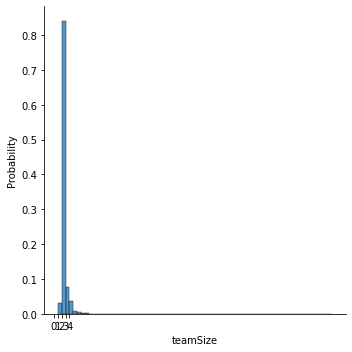

In [23]:
# limiting team size to four to exclude custom modes
# checking if there are any duos with more than two players,
# which would indicate an error
duos = data.loc[data['matchType'] == 'duo']
sns.displot(x='teamSize', stat='probability', bins=4, binwidth=1, data=duos)
plt.xticks(range(0,5))

so it looks like something is wrong with the group size aggregator. we'll have to cross-validate it with the match type 

In [24]:
# for df in dataframes:
#    solo_drop = df.loc[(df['matchType'] == 'solo') & (df['teamSize'] > 1)]
#    duo_drop = df.loc[(df['matchType'] == 'duo') & (df['teamSize'] > 2)]
#    squad_drop = df.loc[(df['matchType'] == 'squad') & (df['teamSize'] > 4)]
#
#    df = df[~df.isin(solo_drop)].dropna()
#    df = df[~df.isin(duo_drop)].dropna()
#    df = df[~df.isin(squad_drop)].dropna()

drop = ['winPlacePerc', 'fpp', 'teamKills',
        'numGroups', 'maxPlace', 'matchDuration']

team_means = team_values.drop(drop, axis=1)
#team_means_train = team_values_train.drop(drop, axis=1)
#team_means_test = team_values_test.drop(drop, axis=1)

#means = [team_means_train, team_means_test]
cols = ['groupId']
#for df in means:
for col in team_means.columns:
    if col != 'groupId':
        new_col = (str(col) + 'TeamMean')
        cols.append(new_col)
team_means.columns = cols

team_means = team_means.merge(team_size, on='groupId')
# team_means_train = team_means_train.merge(team_size_train, on='groupId')
# team_means_test = team_means_test.merge(team_size_test, on='groupId')

#for df in means:
for col in team_means.columns:
    if (col != 'groupId') and (col != 'teamSize'):
        team_means[col] = (team_means[col] / team_means.teamSize)
# team_means = team_means.drop([''])

#train = train.merge(team_means_train.drop('teamSize', axis=1), on='groupId')
#test = test.merge(team_means_test.drop('teamSize', axis=1), on='groupId')
#test.head()

data =  data.merge(team_means.drop('teamSize', axis=1), on='groupId')
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,pct_headshot,fpp,teamSize,assistsTeamMean,boostsTeamMean,damageDealtTeamMean,DBNOsTeamMean,headshotKillsTeamMean,healsTeamMean,killPlaceTeamMean,killPointsTeamMean,killsTeamMean,killStreaksTeamMean,longestKillTeamMean,rankPointsTeamMean,revivesTeamMean,rideDistanceTeamMean,roadKillsTeamMean,swimDistanceTeamMean,vehicleDestroysTeamMean,walkDistanceTeamMean,weaponsAcquiredTeamMean,winPointsTeamMean,totalDistanceTeamMean,pct_headshotTeamMean
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,244.8000,NaN,True,4,0.0,0.0,102.1875,0.5,0.25,0.00,47.25,1250.5,1.0,0.25,6.91500,-1.00,0.0,0.000000,0.0,0.00,0.0,182.99,1.25,1476.25,182.990000,0.0625
1,7516514fbd1091,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,62,1232,0,0,0.00,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,48.28,1,1465,0.4444,48.2800,NaN,True,4,0.0,0.0,102.1875,0.5,0.25,0.00,47.25,1250.5,1.0,0.25,6.91500,-1.00,0.0,0.000000,0.0,0.00,0.0,182.99,1.25,1476.25,182.990000,0.0625
2,c56d45be16aa86,4d4b580de459be,a10357fd1a4a91,0,0,318.00,2,1,0,6,1185,4,1,27.66,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,342.80,2,1476,0.4444,342.8000,0.25,True,4,0.0,0.0,102.1875,0.5,0.25,0.00,47.25,1250.5,1.0,0.25,6.91500,-1.00,0.0,0.000000,0.0,0.00,0.0,182.99,1.25,1476.25,182.990000,0.0625
3,100eef17c4d773,4d4b580de459be,a10357fd1a4a91,0,0,90.75,0,0,0,61,1344,0,0,0.00,1306,squad,28,26,-1,0,0.0000,0,0.00,0,0,96.08,1,1498,0.4444,96.0800,NaN,True,4,0.0,0.0,102.1875,0.5,0.25,0.00,47.25,1250.5,1.0,0.25,6.91500,-1.00,0.0,0.000000,0.0,0.00,0.0,182.99,1.25,1476.25,182.990000,0.0625
4,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,1445.0445,NaN,True,4,0.5,1.5,142.8175,0.5,0.00,3.25,37.00,0.0,1.0,0.75,20.91225,1482.75,0.0,3197.001125,0.0,2.76,0.0,1892.75,6.00,0.00,5092.511125,0.0000


In [25]:
data.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,pct_headshot,fpp,teamSize,assistsTeamMean,boostsTeamMean,damageDealtTeamMean,DBNOsTeamMean,headshotKillsTeamMean,healsTeamMean,killPlaceTeamMean,killPointsTeamMean,killsTeamMean,killStreaksTeamMean,longestKillTeamMean,rankPointsTeamMean,revivesTeamMean,rideDistanceTeamMean,roadKillsTeamMean,swimDistanceTeamMean,vehicleDestroysTeamMean,walkDistanceTeamMean,weaponsAcquiredTeamMean,winPointsTeamMean,totalDistanceTeamMean,pct_headshotTeamMean
6381135,dadb017a444602,97572de2a4da68,00eaf1db913030,0,0,100.00,0,0,0,40,0,1,1,4.07,1441,solo,94,93,1477,0,0.0,0,0.0,0,0,91.190,1,0,NaN,91.190,0.0,True,1,0.0,0.0,100.00,0.0,0.0,0.0,40.0,0.0,1.0,1.0,4.07,1477.0,0.0,0.0,0.0,0.0,0.0,91.190,1.0,0.0,91.190,0.0
6381136,4e876c8d185011,7e3ffcf069160d,d75584b6a89a04,0,0,42.57,0,0,0,66,1479,0,0,0.00,1362,solo,98,95,-1,0,0.0,0,0.0,0,0,299.600,1,1614,NaN,299.600,NaN,True,1,0.0,0.0,42.57,0.0,0.0,0.0,66.0,1479.0,0.0,0.0,0.00,-1.0,0.0,0.0,0.0,0.0,0.0,299.600,1.0,1614.0,299.600,0.0
6381137,130020cd922eb9,355623b5def3e6,bdd686c2da1b5a,0,0,11.02,0,0,0,79,0,0,0,0.00,1854,solo,98,98,1491,0,0.0,0,0.0,0,0,117.000,2,0,NaN,117.000,NaN,True,1,0.0,0.0,11.02,0.0,0.0,0.0,79.0,0.0,0.0,0.0,0.00,1491.0,0.0,0.0,0.0,0.0,0.0,117.000,2.0,0.0,117.000,0.0
6381138,760e8d8f9a798d,a64e0c1ca94fb2,e21d178e2e5eeb,0,0,0.00,0,0,2,57,0,0,0,0.00,1421,solo,98,96,1500,0,0.0,0,0.0,0,0,633.600,4,0,NaN,633.600,NaN,True,1,0.0,0.0,0.00,0.0,0.0,2.0,57.0,0.0,0.0,0.0,0.00,1500.0,0.0,0.0,0.0,0.0,0.0,633.600,4.0,0.0,633.600,0.0
6381139,1e1c6afbf5d717,f430f8a8efe1e9,aa589428036d12,0,0,45.72,0,0,0,94,0,0,0,0.00,1306,solo,94,92,1500,0,0.0,0,0.0,0,0,4.889,0,0,NaN,4.889,NaN,True,1,0.0,0.0,45.72,0.0,0.0,0.0,94.0,0.0,0.0,0.0,0.00,1500.0,0.0,0.0,0.0,0.0,0.0,4.889,0.0,0.0,4.889,0.0


In [26]:
data['fpp'] = data.fpp.astype(int)
data['teamSize'] = data.teamSize.astype(int)

# let's see if the team variables I created are more predictive

In [27]:
data.corr()['winPlacePerc'].sort_values(ascending=False)

winPlacePerc               1.000000
walkDistanceTeamMean       0.841037
walkDistance               0.810888
boostsTeamMean             0.716078
totalDistanceTeamMean      0.698391
totalDistance              0.677037
weaponsAcquiredTeamMean    0.675383
boosts                     0.634234
weaponsAcquired            0.583806
damageDealtTeamMean        0.549442
killsTeamMean              0.525777
longestKillTeamMean        0.521806
healsTeamMean              0.511747
killStreaksTeamMean        0.511040
damageDealt                0.440507
heals                      0.427857
kills                      0.419916
longestKill                0.410154
assistsTeamMean            0.399393
DBNOsTeamMean              0.392922
killStreaks                0.377566
headshotKillsTeamMean      0.368241
revivesTeamMean            0.360267
rideDistanceTeamMean       0.358402
rideDistance               0.342915
assists                    0.299441
DBNOs                      0.279970
headshotKills              0

1. aggregate teams
2. Calculate if there are laggards in the team in things like walkDistance, as that will predict if a teammate died early.
3. col with # in team
4. Calculate averages so they are on same scale regardless 

5. convert 0s in elo points to NaNs to fix the distribution

In [28]:
train, test = split_data(data)

train = train.dropna()
test = test.dropna()
 
X_train = train.drop(['winPlacePerc'], axis=1)
y_train = train.winPlacePerc.values

X_test = test

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [30]:
ohe = OneHotEncoder(handle_unknown='ignore')
model = RandomForestRegressor(n_estimators = 100, verbose=True)
X_train = ohe.fit_transform(train)
X_test = ohe.fit_transform(test  

In [ ]:
model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
from sklearn.metrics import mean_absolute_error
